In [10]:
# !uv init && uv venv && source .venv/bin/activate
!uv sync

Resolved 72 packages in 3ms
Audited 66 packages in 0.07ms


In [1]:
import warnings

import joblib
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

warnings.filterwarnings("ignore")

In [3]:
df = pl.read_csv("data/dataset.csv")
print("Dataset loaded successfully")
print(f"Shape: {df.shape}")

Dataset loaded successfully
Shape: (676, 30)


In [4]:
print("First 5 rows:")
df.head()

First 5 rows:


product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_score,customers,weekday,weekend,holiday,month,year,s,volume,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
str,str,str,i64,f64,f64,f64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""bed1""","""bed_bath_table""","""01-05-2017""",1,45.95,15.1,45.95,39,161,2,350,4.0,57,23,8,1,5,2017,10.267394,3800,89.9,3.9,15.011897,215.0,4.4,8.76,45.95,4.0,15.1,45.9
"""bed1""","""bed_bath_table""","""01-06-2017""",3,137.85,12.933333,45.95,39,161,2,350,4.0,61,22,8,1,6,2017,6.503115,3800,89.9,3.9,14.769216,209.0,4.4,21.322,45.95,4.0,12.933333,45.95
"""bed1""","""bed_bath_table""","""01-07-2017""",6,275.7,14.84,45.95,39,161,2,350,4.0,123,21,10,1,7,2017,12.071651,3800,89.9,3.9,13.993833,205.0,4.4,22.195932,45.95,4.0,14.84,45.95
"""bed1""","""bed_bath_table""","""01-08-2017""",4,183.8,14.2875,45.95,39,161,2,350,4.0,90,23,8,1,8,2017,9.293873,3800,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.2875,45.95
"""bed1""","""bed_bath_table""","""01-09-2017""",2,91.9,15.1,45.95,39,161,2,350,4.0,54,21,9,1,9,2017,5.555556,3800,89.9,3.9,18.776522,163.39871,4.4,24.324687,45.95,4.0,15.1,45.95


In [5]:
null_counts = df.null_count()
print("Missing values per column:")
null_counts

Missing values per column:


product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_score,customers,weekday,weekend,holiday,month,year,s,volume,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
duplicate_count = df.height - df.unique().height
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [7]:
print("Dataset info:")
print(f"Rows: {df.height}")
print(f"Columns: {df.width}")
print(f"Product categories: {df.select('product_category_name').n_unique()}")
print(f"Unique products: {df.select('product_id').n_unique()}")

Dataset info:
Rows: 676
Columns: 30
Product categories: 9
Unique products: 52


In [8]:
price_stats = df.select(
    [
        pl.col("unit_price").quantile(0.25).alias("q1"),
        pl.col("unit_price").quantile(0.75).alias("q3"),
        pl.col("unit_price").median().alias("median"),
        pl.col("unit_price").mean().alias("mean"),
    ]
)
print("Unit price statistics:")
print(price_stats)

Unit price statistics:
shape: (1, 4)
┌──────┬────────┬────────┬──────────┐
│ q1   ┆ q3     ┆ median ┆ mean     │
│ ---  ┆ ---    ┆ ---    ┆ ---      │
│ f64  ┆ f64    ┆ f64    ┆ f64      │
╞══════╪════════╪════════╪══════════╡
│ 53.9 ┆ 129.99 ┆ 89.9   ┆ 106.4968 │
└──────┴────────┴────────┴──────────┘


In [9]:
iqr_analysis = df.select(
    [
        (pl.col("qty").quantile(0.80) - pl.col("qty").quantile(0.20)).alias(
            "qty_iqr"
        ),
        pl.col("qty").quantile(0.20).alias("qty_q1"),
        pl.col("qty").quantile(0.80).alias("qty_q3"),
    ]
)
print("Quantity IQR analysis:")
print(iqr_analysis)

Quantity IQR analysis:
shape: (1, 3)
┌─────────┬────────┬────────┐
│ qty_iqr ┆ qty_q1 ┆ qty_q3 │
│ ---     ┆ ---    ┆ ---    │
│ f64     ┆ f64    ┆ f64    │
╞═════════╪════════╪════════╡
│ 18.0    ┆ 4.0    ┆ 22.0   │
└─────────┴────────┴────────┘


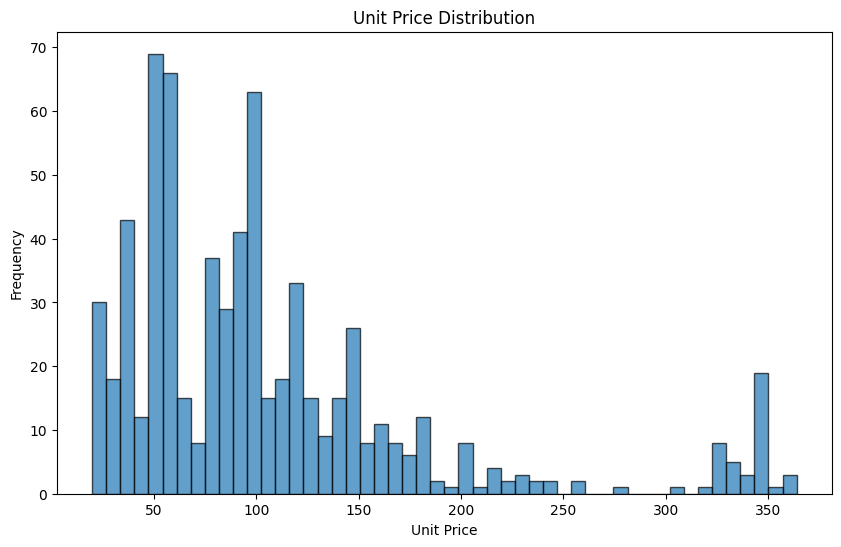

In [10]:
plt.figure(figsize=(10, 6))
price_data = df.select("unit_price").to_numpy().flatten()
plt.hist(price_data, bins=50, alpha=0.7, edgecolor="black")
plt.title("Unit Price Distribution")
plt.xlabel("Unit Price")
plt.ylabel("Frequency")
plt.show()

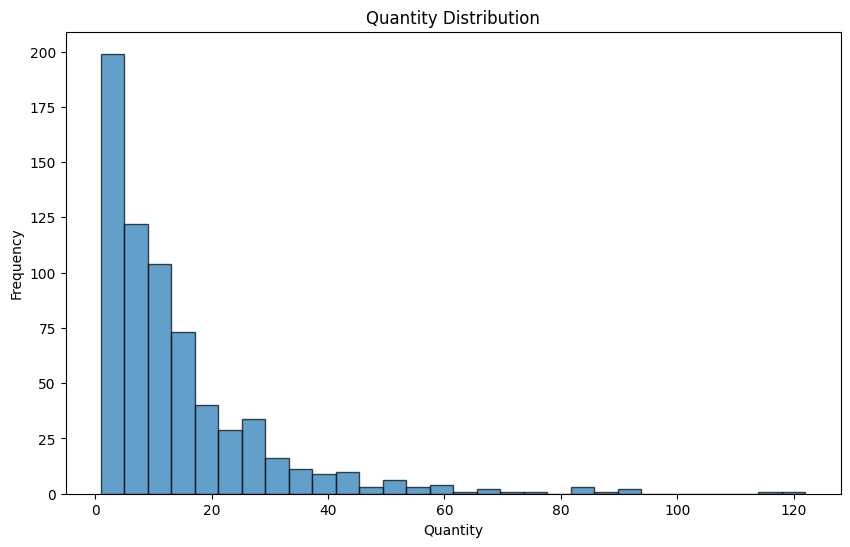

In [11]:
plt.figure(figsize=(10, 6))
qty_data = df.select("qty").to_numpy().flatten()
plt.hist(qty_data, bins=30, alpha=0.7, edgecolor="black")
plt.title("Quantity Distribution")
plt.xlabel("Quantity")
plt.ylabel("Frequency")
plt.show()

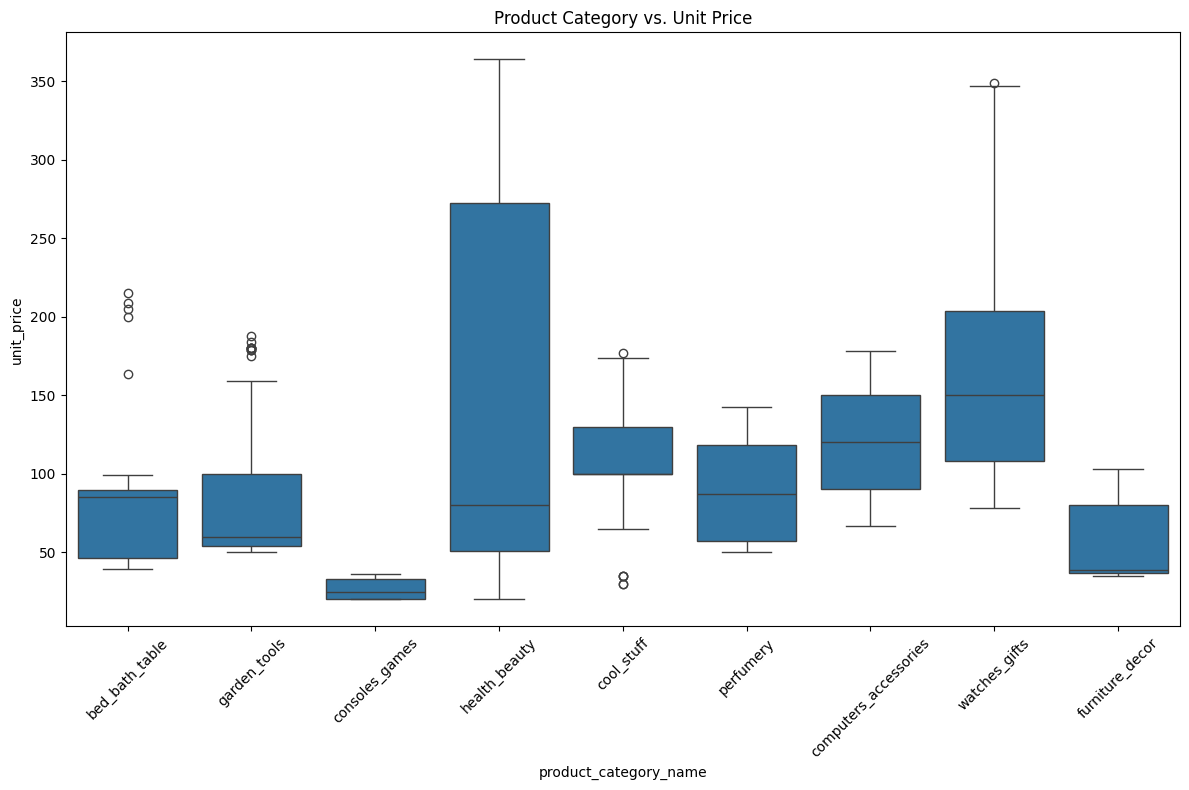

In [12]:
# Convert to format seaborn can use
plot_data = df.select(["product_category_name", "unit_price"]).to_pandas()
plt.figure(figsize=(12, 8))
sns.boxplot(x="product_category_name", y="unit_price", data=plot_data)
plt.title("Product Category vs. Unit Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

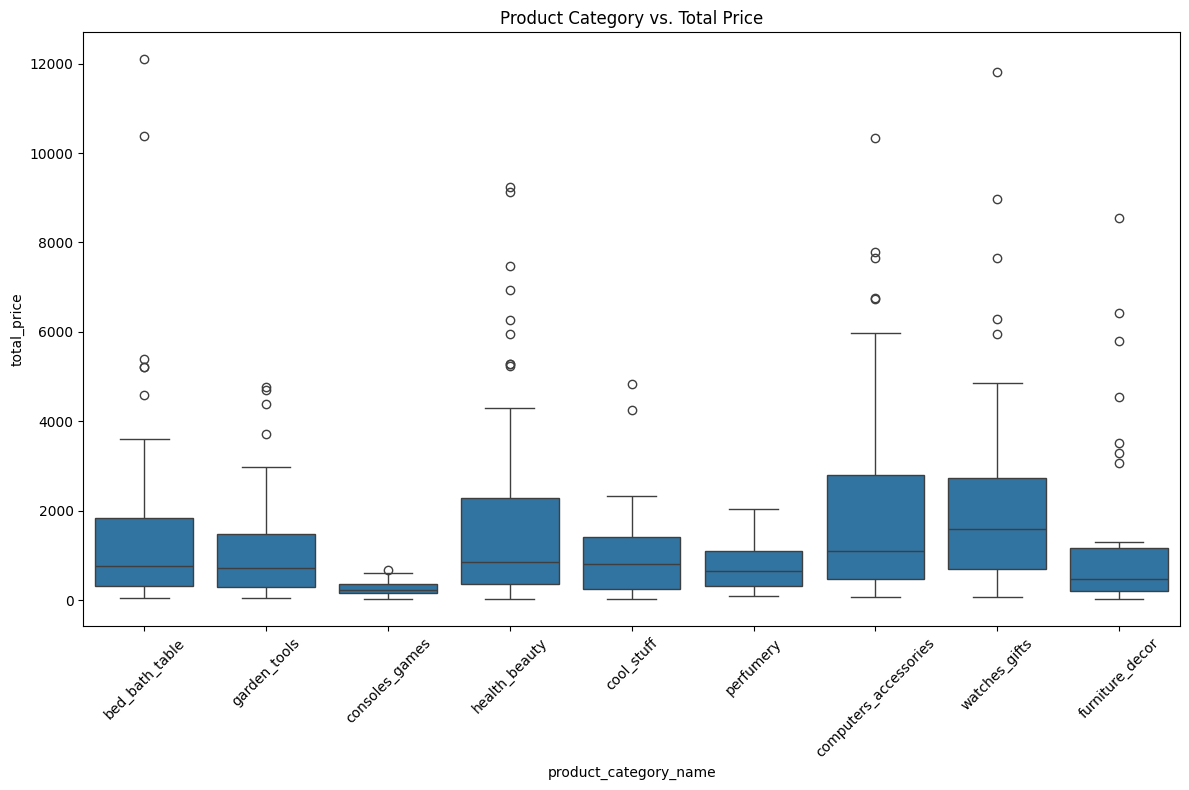

In [13]:
plot_data2 = df.select(["product_category_name", "total_price"]).to_pandas()
plt.figure(figsize=(12, 8))
sns.boxplot(x="product_category_name", y="total_price", data=plot_data2)
plt.title("Product Category vs. Total Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

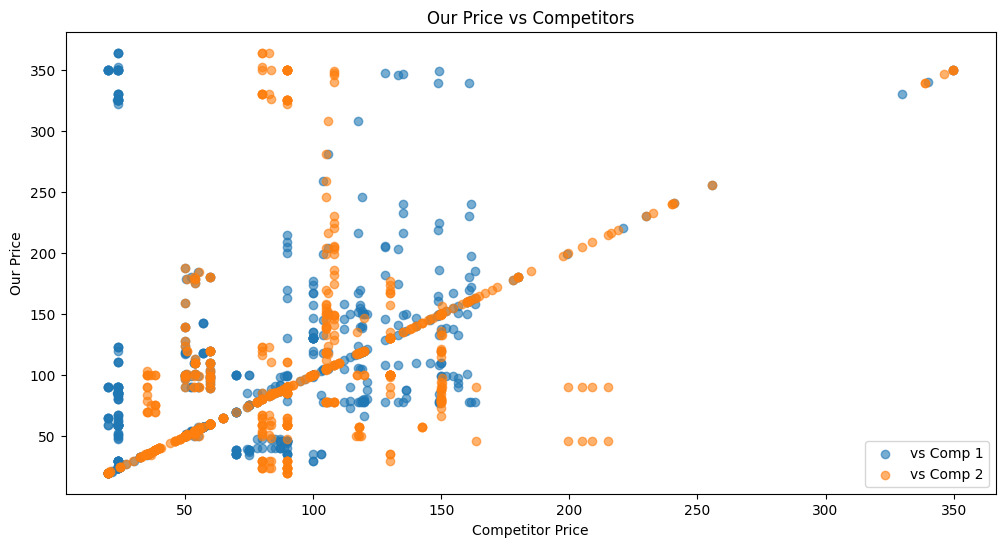

In [15]:
comp_data = df.select(["unit_price", "comp_1", "comp_2", "comp_3"]).to_pandas()
plt.figure(figsize=(12, 6))
plt.scatter(
    comp_data["comp_1"], comp_data["unit_price"], alpha=0.6, label="vs Comp 1"
)
plt.scatter(
    comp_data["comp_2"], comp_data["unit_price"], alpha=0.6, label="vs Comp 2"
)
plt.xlabel("Competitor Price")
plt.ylabel("Our Price")
plt.title("Our Price vs Competitors")
plt.legend()
plt.show()

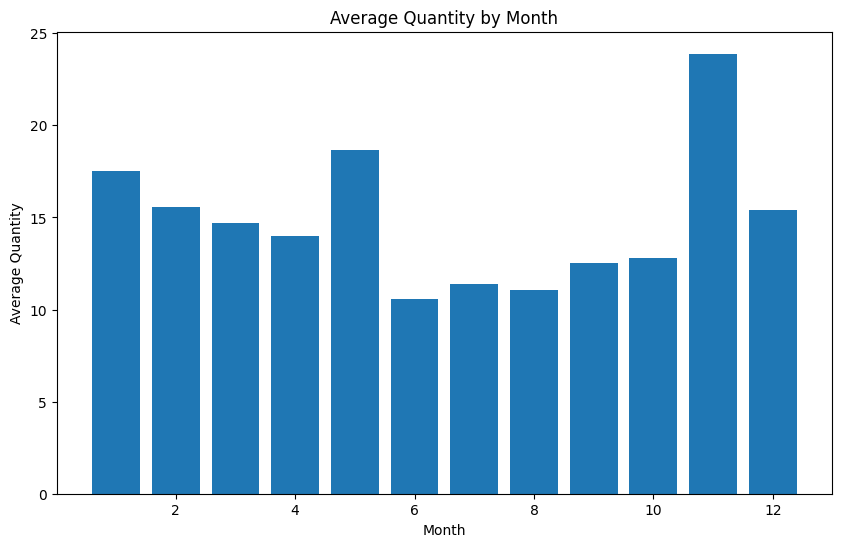

In [16]:
seasonal_qty = df.group_by("month").agg(pl.col("qty").mean().alias("avg_qty"))
seasonal_data = seasonal_qty.to_pandas()
plt.figure(figsize=(10, 6))
plt.bar(seasonal_data["month"], seasonal_data["avg_qty"])
plt.title("Average Quantity by Month")
plt.xlabel("Month")
plt.ylabel("Average Quantity")
plt.show()

In [17]:
# Create demand categories based on quantity quartiles
qty_quartiles = df.select(
    [
        pl.col("qty").quantile(0.25).alias("low_threshold"),
        pl.col("qty").quantile(0.75).alias("high_threshold"),
    ]
)

low_thresh = qty_quartiles.select("low_threshold").item()
high_thresh = qty_quartiles.select("high_threshold").item()

df = df.with_columns(
    [
        pl.when(pl.col("qty") <= low_thresh)
        .then(0)
        .when(pl.col("qty") <= high_thresh)
        .then(1)
        .otherwise(2)
        .alias("demand_category")
    ]
)

print(f"Demand thresholds: Low <= {low_thresh:.1f}, High > {high_thresh:.1f}")

Demand thresholds: Low <= 4.0, High > 18.0


In [18]:
target_dist = df.group_by("demand_category").agg(pl.count().alias("count"))
print("Demand category distribution:")
print(target_dist)

Demand category distribution:
shape: (3, 2)
┌─────────────────┬───────┐
│ demand_category ┆ count │
│ ---             ┆ ---   │
│ i32             ┆ u32   │
╞═════════════════╪═══════╡
│ 0               ┆ 170   │
│ 1               ┆ 340   │
│ 2               ┆ 166   │
└─────────────────┴───────┘


In [19]:
df = df.with_columns(
    [
        # Price ratios
        (pl.col("unit_price") / pl.col("comp_1")).alias("price_ratio_comp1"),
        (pl.col("unit_price") / pl.col("comp_2")).alias("price_ratio_comp2"),
        # Price position vs competitors
        pl.when(pl.col("unit_price") < pl.col("comp_1"))
        .then(1)
        .otherwise(0)
        .alias("cheaper_than_comp1"),
        # Product characteristics
        (
            pl.col("product_name_lenght") / pl.col("product_description_lenght")
        ).alias("name_desc_ratio"),
        # Revenue per customer
        (pl.col("total_price") / pl.col("customers")).alias(
            "revenue_per_customer"
        ),
    ]
)

In [20]:
feature_cols = [
    "unit_price",
    "freight_price",
    "product_score",
    "customers",
    "weekday",
    "weekend",
    "holiday",
    "month",
    "volume",
    "comp_1",
    "comp_2",
    "comp_3",
    "product_weight_g",
    "product_photos_qty",
    "price_ratio_comp1",
    "price_ratio_comp2",
    "cheaper_than_comp1",
    "revenue_per_customer",
]

In [21]:
model_data = df.select(feature_cols + ["demand_category"]).fill_null(0)
X = model_data.select(feature_cols).to_numpy()
y = model_data.select("demand_category").to_numpy().flatten()

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Feature matrix shape: (676, 18)
Target vector shape: (676,)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 338
Test set size: 338


In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV # Import GridSearchCV

dt_params = {
    "max_depth": [5, 10, 15, 20, None],
    "min_samples_split": [2, 10, 20],
    "min_samples_leaf": [1, 5, 10],
    "criterion": ["gini", "entropy"],
}

dt = DecisionTreeClassifier(random_state=42)
# Use GridSearchCV instead of RandomizedSearchCV
dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring="accuracy", n_jobs=-1)

In [24]:
# Fit the GridSearchCV to the training data
dt_grid.fit(X_train, y_train)
best_dt = dt_grid.best_estimator_

print(f"Best Decision Tree parameters: {dt_grid.best_params_}")
print(f"Best cross-validation score: {dt_grid.best_score_:.3f}")

Best Decision Tree parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score: 0.701


In [25]:
y_pred = best_dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test accuracy: {accuracy:.3f}")

Test accuracy: 0.775


In [26]:
print("Classification Report:")
print(
    classification_report(
        y_test,
        y_pred,
        target_names=["Low Demand", "Medium Demand", "High Demand"],
    )
)

Classification Report:
               precision    recall  f1-score   support

   Low Demand       0.90      0.93      0.91        85
Medium Demand       0.80      0.74      0.77       170
  High Demand       0.62      0.70      0.66        83

     accuracy                           0.78       338
    macro avg       0.77      0.79      0.78       338
 weighted avg       0.78      0.78      0.78       338



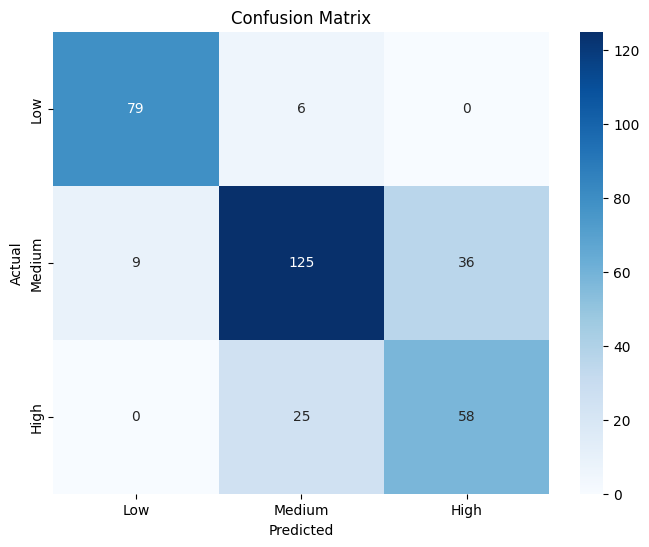

In [27]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Low", "Medium", "High"],
    yticklabels=["Low", "Medium", "High"],
)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [28]:
feature_importance = best_dt.feature_importances_
importance_df = pl.DataFrame(
    {"feature": feature_cols, "importance": feature_importance}
).sort("importance", descending=True)

print("Top 10 most important features:")
print(importance_df.head(10))

Top 10 most important features:
shape: (10, 2)
┌──────────────────────┬────────────┐
│ feature              ┆ importance │
│ ---                  ┆ ---        │
│ str                  ┆ f64        │
╞══════════════════════╪════════════╡
│ revenue_per_customer ┆ 0.329667   │
│ customers            ┆ 0.296867   │
│ unit_price           ┆ 0.167386   │
│ price_ratio_comp2    ┆ 0.06209    │
│ freight_price        ┆ 0.035778   │
│ comp_3               ┆ 0.028141   │
│ comp_1               ┆ 0.019055   │
│ weekday              ┆ 0.018515   │
│ weekend              ┆ 0.015716   │
│ price_ratio_comp1    ┆ 0.013153   │
└──────────────────────┴────────────┘


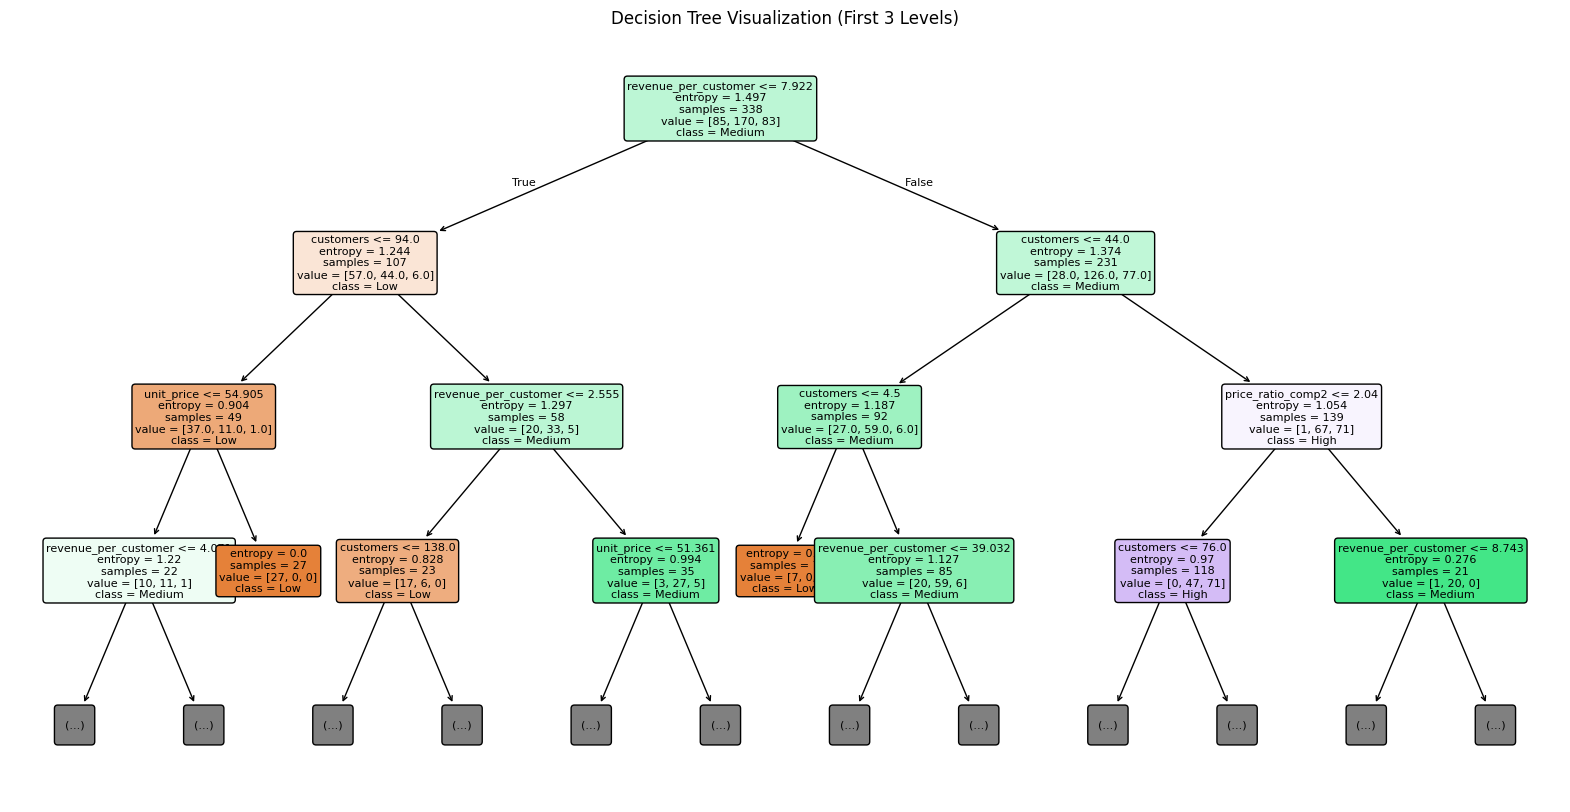

In [29]:
plt.figure(figsize=(20, 10))
plot_tree(
    best_dt,
    feature_names=feature_cols,
    class_names=["Low", "Medium", "High"],
    filled=True,
    rounded=True,
    fontsize=8,
    max_depth=3,
)
plt.title("Decision Tree Visualization (First 3 Levels)")
plt.show()

In [33]:
joblib.dump(best_dt, "model.pkl")

model_metadata = {
    "model_type": "DecisionTreeClassifier",
    "features": feature_cols,
    "best_params": dt_grid.best_params_,
    "test_accuracy": accuracy,
    "demand_thresholds": {"low": low_thresh, "high": high_thresh},
}

joblib.dump(model_metadata, "data/dt_metadata.pkl")
print("Decision tree model and metadata saved successfully!")

Decision tree model and metadata saved successfully!


In [31]:
def predict_demand_category(model, features):
    """
    Predict demand category for new data
    """
    prediction = model.predict([features])[0]
    probabilities = model.predict_proba([features])[0]

    categories = ["Low Demand", "Medium Demand", "High Demand"]
    return categories[prediction], probabilities

In [32]:
sample_features = X_test[0]
category, probs = predict_demand_category(best_dt, sample_features)
print(f"Sample prediction: {category}")
print(f"Probabilities: {probs}")
print(f"Actual: {['Low Demand', 'Medium Demand', 'High Demand'][y_test[0]]}")

Sample prediction: High Demand
Probabilities: [0. 0. 1.]
Actual: Medium Demand
